In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn


_ = torch.manual_seed(9527)
np.random.seed(9527)

%matplotlib inline

# 損失函數

## Binary Cross Entropy

### `nn.BCEWithLogitsLoss`

The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

$$
    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = - w_n \left[ y_n \cdot \log \sigma(x_n)
    + (1 - y_n) \cdot \log (1 - \sigma(x_n)) \right],
$$

where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
(default ``'mean'``), then

$$
    \ell(x, y) = \begin{cases}
        \operatorname{mean}(L), & \text{if reduction} = \text{'mean';}\\
        \operatorname{sum}(L),  & \text{if reduction} = \text{'sum'.}
    \end{cases}
$$

### `nn.BCELoss`

The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

$$
    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right],
$$

where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
(default ``'mean'``), then

$$
    \ell(x, y) = \begin{cases}
        \operatorname{mean}(L), & \text{if reduction} = \text{'mean';}\\
        \operatorname{sum}(L),  & \text{if reduction} = \text{'sum'.}
    \end{cases}
$$

In [ ]:
y_true = torch.tensor([0., 0, 0, 0, 1, 1, 1, 1]).unsqueeze(-1)
x = torch.randn(y_true.shape)
x, x.shape

(tensor([[-0.3873],
         [-0.3489],
         [-0.2390],
         [ 0.8479],
         [ 0.0697],
         [ 0.3923],
         [ 0.2987],
         [ 0.5701]]),
 torch.Size([8, 1]))

In [ ]:
model = nn.Linear(1, 1)
loss_logits_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCELoss()

logits = model(x)
logits

tensor([[-0.5933],
        [-0.6032],
        [-0.6314],
        [-0.9109],
        [-0.7108],
        [-0.7937],
        [-0.7697],
        [-0.8394]], grad_fn=<AddmmBackward>)

In [ ]:
loss_logits = loss_logits_fn(logits, y_true)
loss = loss_fn(torch.sigmoid(logits), y_true)

assert logits.shape == y_true.shape
loss, loss_logits

(tensor(0.7833, grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.7833, grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

手動計算

In [ ]:
xn = torch.sigmoid(logits)
yn = y_true
qx = torch.where(yn == 1, xn, 1 - xn)
qx

tensor([[0.6441],
        [0.6464],
        [0.6528],
        [0.7132],
        [0.3294],
        [0.3114],
        [0.3165],
        [0.3017]], grad_fn=<SWhereBackward>)

In [ ]:
bce = -torch.log(qx).mean()
bce, loss

(tensor(0.7833, grad_fn=<NegBackward>),
 tensor(0.7833, grad_fn=<BinaryCrossEntropyBackward>))

## Cross Entropy

### `nn.LogSoftmax`

Applies the $\log(\text{Softmax}(x))$ function to an n-dimensional
input Tensor. The LogSoftmax formulation can be simplified as:

$$
\text{LogSoftmax}(x_{i}) = \log\left(\frac{\exp(x_i) }{ \sum_j \exp(x_j)} \right)
$$

In [ ]:
bs = 8
n_classes = 3

y = torch.empty(bs).random_(n_classes).long()
logits = torch.randn(bs, n_classes)
y, logits

(tensor([1, 1, 1, 0, 1, 1, 0, 0]),
 tensor([[ 0.9048,  0.6755,  0.9903],
         [ 0.2776, -1.3566,  1.6334],
         [ 0.4503, -1.3618,  0.3541],
         [-0.3988,  0.1826,  0.0920],
         [ 1.1955, -0.2760,  1.4148],
         [-0.9025, -0.9789, -2.5238],
         [ 0.1882,  0.1807,  1.7570],
         [-0.6205, -0.6331, -1.2318]]))

In [ ]:
minus_self_info = nn.LogSoftmax(dim=1)(logits)
minus_self_info

tensor([[-1.0593, -1.2886, -0.9738],
        [-1.6243, -3.2585, -0.2685],
        [-0.7283, -2.5404, -0.8245],
        [-1.4866, -0.9052, -0.9958],
        [-0.9062, -2.3777, -0.6868],
        [-0.7533, -0.8298, -2.3746],
        [-1.9160, -1.9235, -0.3471],
        [-0.9283, -0.9409, -1.5396]])

In [ ]:
minus_self_info1 = torch.log(torch.softmax(logits, dim=1))
minus_self_info1

tensor([[-1.0593, -1.2886, -0.9738],
        [-1.6243, -3.2585, -0.2685],
        [-0.7283, -2.5404, -0.8245],
        [-1.4866, -0.9052, -0.9958],
        [-0.9062, -2.3777, -0.6868],
        [-0.7533, -0.8298, -2.3746],
        [-1.9160, -1.9235, -0.3471],
        [-0.9283, -0.9409, -1.5396]])

### `nn.NLLLoss`

The negative log likelihood loss. It is useful to train a classification problem with `C` classes.

The `input` given through a forward call is expected to contain **log-probabilities** of each class. `input` has to be a Tensor of size either
$(minibatch, C)$ or $(minibatch, C, d_1, d_2, ..., d_K)$
with $K \geq 1$ for the `K`-dimensional case (described later).

Obtaining **log-probabilities** in a neural network is easily achieved by adding a  `LogSoftmax`  layer in the last layer of your network.
You may use `CrossEntropyLoss` instead, if you prefer not to add an extra layer.

The `target` that this loss expects should be a class index in the range $[0, C-1]$ where `C = number of classes`; if `ignore_index` is specified, this loss also accepts
this class index (this index may not necessarily be in the class range).

The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

$$
    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = - w_{y_n} x_{n,y_n}, \quad
    w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore\_index}\},
$$

where $N$ is the batch size. If :attr:`reduction` is not ``'none'``
(default ``'mean'``), then

$$
    \ell(x, y) = \begin{cases}
        \sum_{n=1}^N \frac{1}{\sum_{n=1}^N w_{y_n}} l_n, &
        \text{if reduction} = \text{'mean';}\\
        \sum_{n=1}^N l_n,  &
        \text{if reduction} = \text{'sum'.}
    \end{cases}
$$

In [ ]:
nll_loss_none = nn.NLLLoss(reduction="none")(minus_self_info, y.long())
nll_loss_none

tensor([1.2886, 3.2585, 2.5404, 1.4866, 2.3777, 0.8298, 1.9160, 0.9283])

In [ ]:
y, y.view(-1, 1), minus_self_info

(tensor([1, 1, 1, 0, 1, 1, 0, 0]),
 tensor([[1],
         [1],
         [1],
         [0],
         [1],
         [1],
         [0],
         [0]]),
 tensor([[-1.0593, -1.2886, -0.9738],
         [-1.6243, -3.2585, -0.2685],
         [-0.7283, -2.5404, -0.8245],
         [-1.4866, -0.9052, -0.9958],
         [-0.9062, -2.3777, -0.6868],
         [-0.7533, -0.8298, -2.3746],
         [-1.9160, -1.9235, -0.3471],
         [-0.9283, -0.9409, -1.5396]]))

In [ ]:
self_info = -minus_self_info
nll_none_manual = self_info.gather(1, y.view(-1, 1)).T
nll_none_manual

tensor([[1.2886, 3.2585, 2.5404, 1.4866, 2.3777, 0.8298, 1.9160, 0.9283]])

In [ ]:
nll_none_manual.mean(), nn.NLLLoss()(minus_self_info, y.long())

(tensor(1.8282), tensor(1.8282))

In [ ]:
nn.CrossEntropyLoss()(logits, y)

tensor(1.8282)

### `nn.CrossEntropyLoss`

This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.

The `input` is expected to contain **raw, unnormalized scores** for each class.

`input` has to be a Tensor of size either :math:`(minibatch, C)` or
:math:`(minibatch, C, d_1, d_2, ..., d_K)`
with :math:`K \geq 1` for the `K`-dimensional case (described later).

The loss can be described as:

$$
    \text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                   = -x[class] + \log\left(\sum_j \exp(x[j])\right)
$$

or in the case of the :attr:`weight` argument being specified:

$$
    \text{loss}(x, class) = weight[class] \left(-x[class] + \log\left(\sum_j \exp(x[j])\right)\right)
$$

The losses are averaged across observations for each minibatch.

```text
model(x)                        --> logits: unnormalized log prob (bs, classes)
-- exp, softmax (nn.LogSoftmax) --> log probs (bs, classes)
-- 將每個 support/example n 對應到正解 yn 位置的 log prob 加負號 (nn.NLLLoss(reduction="none")
-- 加總平均, mean(-log_probs[class]) nn.NLLLoss() --> nn.CrossEntropyLoss(logits)

針對有 bs 個 supports x 的 minibatch, CE = H(p, q) = Sum(p(x) * -log(q(x))
而每個 x 的出現機率 p(x) 就是 1 / bs, 而依照該 x 的 label_idx， 
我們可以從每一 row 的 log probs[label_idx] 取得對應的 q(x) 並加上負號, （概念上是 nn.NLLLoss(reduction="none"))
接著把所有 p(x) * -log(q(x)) 加起來就是 CE (實際上是用 nn.NLLLoss(reduction="mean") 把所有 -log(q(x)) 加起來平均）
    因為 sum(-log(q(x)) / bs = sum((1/bs) * sum(-log(q(x)))
    也就是說，在 multi-class 的情況， 一個 minibatch 的 CE 就是 sum(-log(q(x))) / bs




-- sum(p(x) * -log(q(x)) for all x --> entropy(p) + KL(p|q)  
--> try to minimize KL(p|q)
```

# 手動 SGD

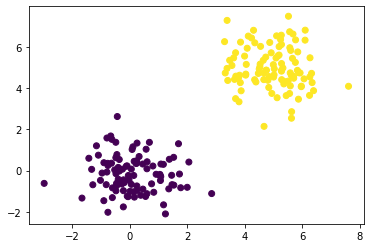

In [ ]:
x = torch.randn(200, 2)
y = torch.empty(200, 1, dtype=torch.float32).random_(2)
x = torch.where(y == 0, x, x + 5)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [ ]:
linear = nn.Linear(2, 1)

model = nn.Sequential(*[
    linear, 
    nn.ReLU(),
])

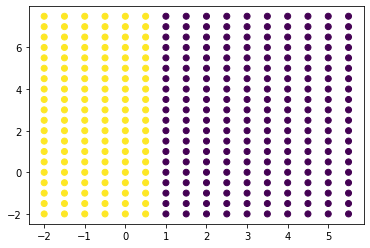

In [ ]:
x1 = torch.arange(-2, 6, step=0.5)
x2 = torch.arange(-2, 8, step=0.5)
grid_x, grid_y = torch.meshgrid([x1, x2])
samples = torch.stack([grid_x.flatten(), grid_y.flatten()]).T

pred = torch.sigmoid(model(samples)).detach()
pred = torch.where(pred > 0.5, torch.ones_like(pred), torch.zeros_like(pred))

plt.scatter(samples[:, 0], samples[:, 1], c=pred);

In [ ]:
lr = 0.01
steps = 100
losses = []

for i in range(steps):
    logits = model(x)
    w, b = linear.weight, linear.bias
    
    loss = loss_logits_fn(logits, y)
    losses.append(loss)
    loss.backward()
    
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

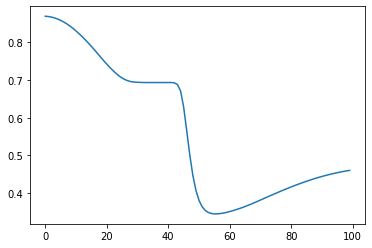

In [ ]:
plt.plot(losses)

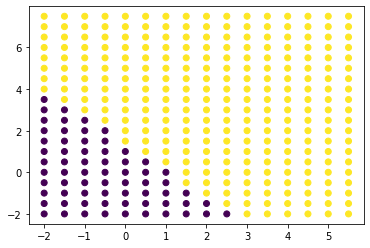

In [ ]:
pred = torch.sigmoid(model(samples)).detach()
pred = torch.where(pred > 0.5, torch.ones_like(pred), torch.zeros_like(pred))

plt.scatter(samples[:, 0], samples[:, 1], c=pred);

## CNN

In [ ]:
permute
view


In [ ]:
pilTrans = transforms.ToTensor()
plt.imshow(pilTrans[1,:])